# Notebook for the paper "Cliche expressions in literature and genre novels"


In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
from collections import defaultdict
import numpy as np
import scipy.stats
import pandas
import seaborn
import matplotlib.pyplot as plt
from nltk import ngrams
from sklearn import feature_selection
%cd /datastore/avcrane1/literariness/
import features
%cd /datastore/avcrane1/cliches/
import postprocess

/datastore/avcrane1/literariness
/datastore/avcrane1/cliches


In [2]:
results = pandas.concat([
        pandas.read_table('cliches/results.tsv', index_col=0),
        pandas.read_csv('../Riddle/metadata.csv', index_col=0),
    ], axis=1, join='inner')
# NB: the following discards 18 novels with less than 2000 sentences,
# which are not part of baselinefeatures.csv.
tmp = pandas.read_csv('../Riddle/baselinefeatures.csv', index_col=0)
results = results.ix[tmp.index]
# Get the complete (document, cliche) matrix of counts:
cliches = postprocess.readmatches('cliches/matches.txt', results.index)

In [3]:
results.index.shape

(383,)

In [4]:
results.columns

Index(['texts', 'sentences', 'matches', '@ 10,000 sentences',
       '@ 10,000 sentences, freq > 1', 'count of most repeated match', 'types',
       'type-token ratio', 'Author', 'Title', 'Category', 'Riddle code',
       'Translated', 'Author gender', 'Author origin', 'Original language',
       'Inclusion criterion', 'Publication date', 'First print', 'Publisher',
       'English title', 'Literary rating', '# literary ratings',
       'Quality rating', '# quality ratings'],
      dtype='object')

In [5]:
FREQLIST = pandas.read_table('/datastore/avcrane1/Riddle/sonar-word.freqsort.lower.gz',
        encoding='utf8', index_col=0, header=None, names=['word', 'count'],
        nrows=20000)
bymatch = pandas.read_table(
        'cliches/bymatch.tsv',
        index_col=0, header=None, names=['text', 'count'])

# The overall most frequent cliches
bymatch.head(10)

,count
text,
' Weet je het zeker ?,307
' Is dat zo ?,245
' Waar heb je het over ?,231
' Laat maar .,140
' Is dat alles ?,139
' Dat meen je niet .,101
' Dat dacht ik al .,101
' Dat meen je niet !,88
' Waarom denk je dat ?,86


## Plots

Baantjer_RatInVal 2.83969465649 77.9280311712
Pauw_Drift 3.84848484848 62.6959247649
Tex_Wachtwoord 4.27272727273 48.3223924143
Dorrestein_Leesclub 4.97654941374 0.0
James_VijftigTintenGrijs 2.115625 23.2835174356
Voskuil_Buurman 6.05315614618 38.9659760502


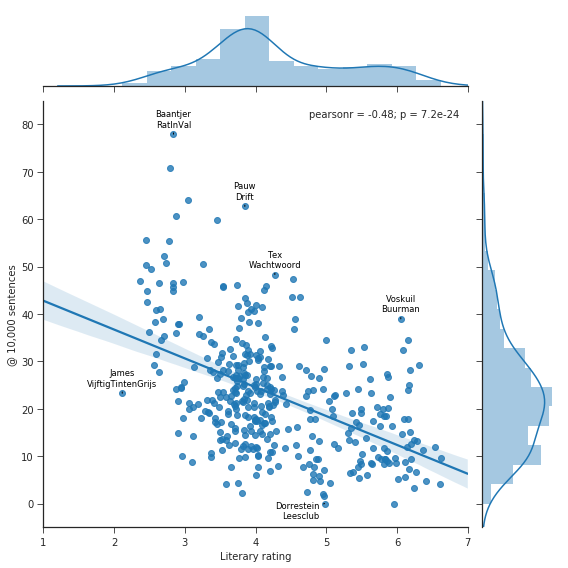

In [6]:
# scatter plot w/some labels
g = seaborn.jointplot('Literary rating', '@ 10,000 sentences', results,
                  xlim=(1, 7), ylim=(-5, 85), kind='reg', size=8)
for label in [
            'Baantjer_RatInVal', 'Pauw_Drift',
            'Tex_Wachtwoord', 'Dorrestein_Leesclub',
            'James_VijftigTintenGrijs',
             'Voskuil_Buurman']:
    x = results['Literary rating'].at[label]
    y = results['@ 10,000 sentences'].at[label]
    print(label, x, y)
    xt = 0
    yt = 15
    ha = 'center'
    if label == 'Dorrestein_Leesclub':
        xt = -5
        yt = -7
        ha = 'right'
    g.ax_joint.annotate(
        label.replace('_', '\n'),
        xy=(x, y),
        xytext=(xt, yt),
        textcoords='offset points',
        color='k', fontsize='small',
        horizontalalignment=ha, verticalalignment='center', 
        arrowprops=dict(facecolor='black', arrowstyle='-'))
g.fig.savefig('/tmp/reg-cliche.pdf')

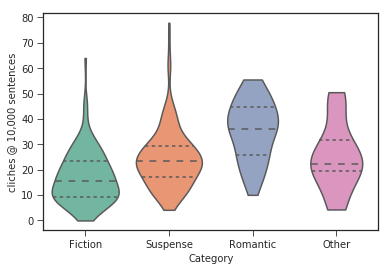

In [7]:
seaborn.violinplot(x='Category', y='cliches @ 10,000 sentences',
        data=results.rename(columns={'@ 10,000 sentences': 'cliches @ 10,000 sentences'}),
        order=['Fiction', 'Suspense', 'Romantic', 'Other'],
        inner="quartiles", palette="Set2", cut=0);
plt.savefig('/tmp/violincliche.pdf')

## Simple textual features

In [8]:
def getstats(tokens):
    result = {}
    text = features.Text.fromtokenized(
            'input', tokens, start=0, end=1000, maxlen=300, lang='nl')
    read = text.readabilityscores()
    basic = text.basicfeatures(freqlist=FREQLIST)
    result['sentences'] = read['r_sentences']
    result['words per sentence'] = read['r_words_per_sentence']
    result['% direct speech sentences'] = basic['b_%_direct_speech']
    result['top3000vocab'] = basic['b_top3000vocab']
    result['bzip2_ratio'] = basic['b_bzip2_ratio']
    return result

refstats = pandas.DataFrame({
    'cliches': getstats('\n'.join(bymatch.index)),
    'lassy': getstats(open('/datastore/avcrane1/data/lassytrain.tok').read()),
    'cgn': getstats(open('/datastore/avcrane1/data/cgn_syn_nl_train.tok').read())
    }).T.drop('sentences', axis=1)

In [9]:
stats = pandas.read_csv('../Riddle/baselinefeatures.csv', index_col=0)
stats.columns

Index(['Literary ratings', 'Quality', 'Category', 'Gender', 'Translated',
       'sentences', 'words', 'characters', 'syllables', 'characters per word',
       'syllables per word', 'words per sentence', 'type_token_ratio',
       'dialogue', '% direct speech sentences', 'questions', '% questions',
       'semicolons', 'aux_after_main', 'aux_before_main', '% aux_after_main',
       '% aux_before_main', 'modifiers', 'constituents',
       '% modifier constituents', 'nouns', 'verbs', 'adverbs', 'adjectives',
       'modifying PPs', 'modifying RELs', 'modifying CPs', 'modifying APs',
       'modifying ADVPs', '% verbs', '% nouns', '% adverbs', '% adjectives',
       '% modifying PPs', '% modifying CPs', '% modifying APs',
       '% modifying ADVPs', '% modifying RELs', 'constituents1', 'NPs',
       'subject_NPs', 'object_NPs', 'top1000vocab', 'top2000vocab',
       'top3000vocab', 'top5000vocab', 'top10000vocab', 'top20000vocab',
       'unknownvocab', 'gzip_ratio', 'bzip2_ratio', 'lzma_

In [10]:
print(pandas.concat([
        pandas.DataFrame({'Novels': 
            stats[['% direct speech sentences', 'bzip2_ratio', 'top3000vocab', 'words per sentence']].mean()
            }).T,
        stats[['Category', '% direct speech sentences', 'bzip2_ratio', 'top3000vocab', 'words per sentence']
            ].groupby('Category').mean(),
        refstats,
    ]).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  \% direct speech sentences &  bzip2\_ratio &  top3000vocab &  words per sentence \\
\midrule
Novels   &                  34.044547 &     0.313538 &      0.833344 &           12.136379 \\
Fiction  &                  27.720274 &     0.318374 &      0.824118 &           13.423845 \\
Other    &                  35.686961 &     0.306851 &      0.839591 &           12.151061 \\
Romantic &                  42.773171 &     0.310939 &      0.844797 &           11.507537 \\
Suspense &                  36.675003 &     0.311266 &      0.837004 &           11.300055 \\
cgn      &                   0.000000 &     0.334600 &      0.811086 &            7.618000 \\
cliches  &                  58.400000 &     0.259332 &      0.967113 &            4.292000 \\
lassy    &                  14.300000 &     0.373167 &      0.734156 &            9.959000 \\
\bottomrule
\end{tabular}



In [11]:
# Correlation of number of cliches with the simple textual features.
feats = [   'words per sentence',
            '% direct speech sentences',
            'top3000vocab',
            'bzip2_ratio']
_, pvalues = feature_selection.f_regression(stats[feats].values, results['@ 10,000 sentences'].values)
x = pandas.DataFrame(
    {a: [stats[a].corr(results['@ 10,000 sentences']), p]
    for a, p in zip(feats, pvalues)}, index=['r', 'p'], columns=feats).T
print(x.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &     r &    p \\
\midrule
words per sentence        & -0.46 &  0.0 \\
\% direct speech sentences &  0.45 &  0.0 \\
top3000vocab              &  0.48 &  0.0 \\
bzip2\_ratio               & -0.29 &  0.0 \\
\bottomrule
\end{tabular}



## Most common cliches by genre

In [12]:
fiction = results.ix[results.Category == 'Fiction'].index
suspense = results.ix[results.Category == 'Suspense'].index
romantic = results.ix[results.Category == 'Romantic'].index
# divide frequency of each cliche by number of novels per genre
# to get expected frequency per novel.
top = pandas.DataFrame({
    'Fiction': cliches.loc[fiction].sum() / (results.Category == 'Fiction').sum(),
    'Suspense': cliches.loc[suspense].sum() / (results.Category == 'Suspense').sum(),
    'Romantic': cliches.loc[romantic].sum() / (results.Category == 'Romantic').sum(),
    })
top.sort_values(by='Fiction', ascending=False).head(10)

,Fiction,Romantic,Suspense
' Weet je het zeker ?,0.463768,1.048780,0.972527
' Is dat zo ?,0.340580,0.634146,0.736264
' Waar heb je het over ?,0.260870,1.024390,0.802198
' Is dat alles ?,0.231884,0.365854,0.467033
' Laat maar .,0.231884,0.487805,0.456044
' Waarom denk je dat ?,0.152174,0.146341,0.302198
Waar of niet ?,0.144928,0.000000,0.098901
Waar heb je het over ?,0.144928,0.170732,0.120879
Maar toch ...,0.137681,0.097561,0.203297
' Weet ik veel .,0.137681,0.341463,0.131868


In [13]:
top.sort_values(by='Suspense', ascending=False).head(10)

,Fiction,Romantic,Suspense
' Weet je het zeker ?,0.463768,1.048780,0.972527
' Waar heb je het over ?,0.260870,1.024390,0.802198
' Is dat zo ?,0.340580,0.634146,0.736264
' Is dat alles ?,0.231884,0.365854,0.467033
' Laat maar .,0.231884,0.487805,0.456044
' Waarom denk je dat ?,0.152174,0.146341,0.302198
' Dat dacht ik al .,0.079710,0.585366,0.291209
' Dat meen je niet .,0.086957,0.878049,0.252747
' Waar gaat het over ?,0.057971,0.146341,0.225275
' Dat kun je wel zeggen .,0.014493,0.146341,0.214286


In [14]:
top.sort_values(by='Romantic', ascending=False).head(10)

,Fiction,Romantic,Suspense
' Dat meen je niet !,0.057971,1.243902,0.109890
' Weet je het zeker ?,0.463768,1.048780,0.972527
' Waar heb je het over ?,0.260870,1.024390,0.802198
' Dat meen je niet .,0.086957,0.878049,0.252747
' Is dat zo ?,0.340580,0.634146,0.736264
' Dat dacht ik al .,0.079710,0.585366,0.291209
' Laat maar .,0.231884,0.487805,0.456044
Ik red me wel .,0.065217,0.463415,0.098901
' Doe niet zo raar .,0.036232,0.463415,0.060440
' Is dat alles ?,0.231884,0.365854,0.467033


# The Cook & Hirst 2013 n-gram method

Cf. http://aclweb.org/anthology/W13-1008

In [15]:
lassyngrams = pandas.read_table('/datastore/avcrane1/lassygroot/lassy-ngrams.txt',
                  index_col=0, usecols=[1], header=0, quoting=3,
                  dtype={1: np.int32}, engine='c')

In [16]:
lassyngrams.size

269528509

In [17]:
%cd /datastore/avcrane1/cliches/
clichelines = open('cliche_matches.txt').read().splitlines()
# NB: reading whole sentence here; could restrict to matching cliche only.
# NB: strip sentence-final period, because it otherwise shows up as an outlier.
# (e.g., the trigram "common_word . _" will be disproportionally common).
# (alternatively, maybe just remove the padding?)
numtokens = sum(len(line.strip('.').split()) for line in clichelines)
clichengrams = {n:
        pandas.Index(' '.join(a)
        for line in clichelines
            for a in ngrams(line.strip('.').split(), n, pad_right=True, right_pad_symbol='_'))
        for n in range(1, 6)}

/datastore/avcrane1/cliches


In [18]:
def samplengrams(filename, numtokens, n):
    # sample lines until we have about as much tokens as for the cliches
    result = {x: list() for x in range(1, n + 1)}
    t = 0
    lines = open(filename).read().splitlines()
    while t < numtokens:
        line = random.choice(lines).strip('.').split()
        t += len(line)
        for x in range(1, n + 1):
            for a in ngrams(line, x, pad_right=True, right_pad_symbol='_'):
                result[x].append(' '.join(a))
    result = {x: pandas.Index(result[x]) for x in range(1, n + 1)}
    return result

cgn = samplengrams('../data/cgn_syn_nl_train.tok', numtokens, 5)
lassytrain = samplengrams('../data/lassytrain.tok', numtokens, 5)

In [19]:
len(lassytrain[1]), len(cgn[1]), len(clichengrams[1])

(13998, 14012, 13991)

In [20]:
len(lassytrain[3]), len(cgn[3]), len(clichengrams[3])

(13998, 14012, 13991)

In [21]:
lassytrain[3]

Index(['Een rol spelen', 'rol spelen ook', 'spelen ook de', 'ook de aanslagen',
       'de aanslagen in', 'aanslagen in Irak', 'in Irak ,', 'Irak , waarbij',
       ', waarbij olie-installaties', 'waarbij olie-installaties vaak',
       ...
       'verschillende soorten _', 'soorten _ _', '« Alles Kan',
       'Alles Kan Beter', 'Kan Beter »', 'Beter » (', '» ( 1997-1999',
       '( 1997-1999 )', '1997-1999 ) _', ') _ _'],
      dtype='object', length=13998)

In [22]:
clichengrams[3]

Index(['Aan mij zal', 'mij zal het', 'zal het niet', 'het niet liggen',
       'niet liggen _', 'liggen _ _', 'Aarde aan Mars', 'aan Mars !',
       'Mars ! _', '! _ _',
       ...
       '' Zullen we', 'Zullen we het', 'we het gezellig',
       'het gezellig houden', 'gezellig houden ?', 'houden ? _', '? _ _',
       '' zwerver '', 'zwerver ' _', '' _ _'],
      dtype='object', length=13991)

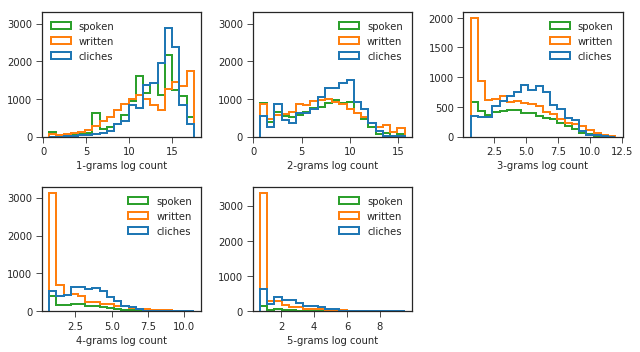

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(9, 5))
xlim = 20; bw=0.5
for n, ax in zip(range(1, 6), axes.reshape((-1, ))):
    a = np.log(lassyngrams.COUNT.ix[cgn[n]].dropna())
    b = np.log(lassyngrams.COUNT.ix[lassytrain[n]].dropna())
    c = np.log(lassyngrams.COUNT.ix[clichengrams[n]].dropna())
    ax.hist([c, b, a], bins=20, label=['cliches', 'written', 'spoken'],
            histtype='step', alpha=1.0, linewidth=2)
    ax.set_xlabel('%d-grams log count' % n)
    ax.legend(loc='best')
    ax.tick_params(axis='x', which='both', bottom='on', top='off')
    ax.tick_params(axis='y', which='both', left='on', right='off')
fig.tight_layout()
axes[1, 2].set_visible(False)
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_ylim(0, 3300); axes[0, 1].set_ylim(0, 3300)
fig.savefig('/tmp/ngramcomp.pdf')

In [24]:
for n in range(1, 6):
    print('n =', n)
    print('lassy<->cliches', scipy.stats.ranksums(lassyngrams.COUNT.ix[lassytrain[n]], lassyngrams.COUNT.ix[clichengrams[n]]))
    print('cgn<->cliches', scipy.stats.ranksums(lassyngrams.COUNT.ix[cgn[n]], lassyngrams.COUNT.ix[clichengrams[n]]))
    print('lassy<->cgn', scipy.stats.ranksums(lassyngrams.COUNT.ix[lassytrain[n]], lassyngrams.COUNT.ix[cgn[n]]))

n = 1
lassy<->cliches RanksumsResult(statistic=-11.165903361368462, pvalue=5.9879356499367859e-29)
cgn<->cliches RanksumsResult(statistic=-17.038821851182558, pvalue=4.2317050031300371e-65)
lassy<->cgn RanksumsResult(statistic=1.2006077538448701, pvalue=0.22990339186452369)
n = 2
lassy<->cliches RanksumsResult(statistic=-6.173336117159848, pvalue=6.686385366347475e-10)
cgn<->cliches RanksumsResult(statistic=8.4232670622169969, pvalue=3.6612861226148262e-17)
lassy<->cgn RanksumsResult(statistic=-14.933760235267449, pvalue=1.9873591660851934e-50)
n = 3
lassy<->cliches RanksumsResult(statistic=-26.603092722688739, pvalue=6.2512187788341364e-156)
cgn<->cliches RanksumsResult(statistic=46.130105886858459, pvalue=0.0)
lassy<->cgn RanksumsResult(statistic=-42.504753290595907, pvalue=0.0)
n = 4
lassy<->cliches RanksumsResult(statistic=5.0299534388607006, pvalue=4.9059895865524642e-07)
cgn<->cliches RanksumsResult(statistic=105.0759753844561, pvalue=0.0)
lassy<->cgn RanksumsResult(statistic=-9.

In [25]:
dorr = samplengrams('../Riddle/tokenized/Dorrestein_Leesclub.tok', numtokens, 5)
spri = samplengrams('../Riddle/tokenized/Springer_Quadriga.tok', numtokens, 5)
buur = samplengrams('../Riddle/tokenized/Voskuil_Buurman.tok', numtokens, 5)

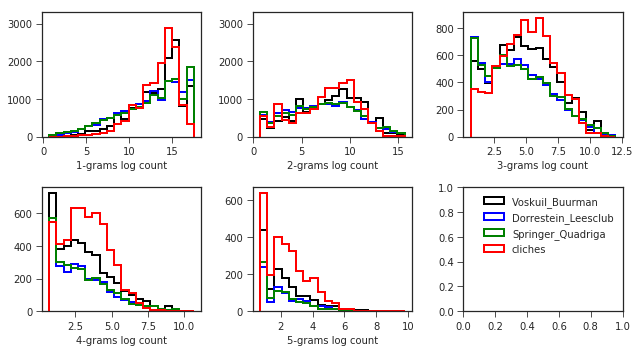

In [26]:
# tokens
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(9, 5))
xlim = 20; bw=0.5
for n, ax in zip(range(1, 6), axes.reshape((-1, ))):
    a = np.log(lassyngrams.COUNT.ix[dorr[n]].dropna())
    b = np.log(lassyngrams.COUNT.ix[spri[n]].dropna())
    c = np.log(lassyngrams.COUNT.ix[clichengrams[n]].dropna())
    d = np.log(lassyngrams.COUNT.ix[buur[n]].dropna())
    ax.hist([c, b, a, d], bins=20, label=['cliches', 'Springer_Quadriga', 'Dorrestein_Leesclub', 'Voskuil_Buurman'],
            histtype='step', alpha=1.0, linewidth=2, color=['r', 'g', 'b', 'k'])
    ax.set_xlabel('%d-grams log count' % n)
    # ax.legend(loc='best')
    ax.tick_params(axis='x', which='both', bottom='on', top='off')
    ax.tick_params(axis='y', which='both', left='on', right='off')
fig.tight_layout()
# axes[1, 2].set_visible(False)
h, l = axes[0, 0].get_legend_handles_labels() 
axes[1, 2].legend(h, l)
axes[0, 0].set_ylim(0, 3300); axes[0, 1].set_ylim(0, 3300)
fig.savefig('/tmp/novelngramcomp.pdf')